# 0) Setup

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask
from cartopy import crs as ccrs, feature as cfeature

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 120

print('xarray', xr.__version__)


xarray 2025.9.0


In [2]:
from dask.distributed import Client
client = Client()  # set up local cluster on my machine
print(client.dashboard_link)

http://127.0.0.1:8787/status


In [3]:
import gcsfs
fs = gcsfs.GCSFileSystem(token="anon")
# Should list arrays/metadata keys under the store
print(fs.ls("gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3")[:10])

['gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zattrs', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zgroup', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/.zmetadata', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/100m_u_component_of_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/100m_v_component_of_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_u_component_of_neutral_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_u_component_of_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_v_component_of_neutral_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_v_component_of_wind', 'gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/10m_wind_gust_since_previous_post_processing']


# 1) Subsetting Precipitation data of Charleston, SC for 20 years

In [4]:
#Opening data
ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    storage_options=dict(token='anon'),
)
ds = ds.sel(time=slice(ds.attrs['valid_time_start'], ds.attrs['valid_time_stop']))

#Define var as precipitation to subset data later.
var = 'total_precipitation'
ds

<xarray.Dataset> Size: 2PB
Dimensions:                                                          (
                                                                      time: 748008,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 6MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 3TB ...
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 3TB ...
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 3TB ...
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 3TB ...
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 3TB ...
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 3TB ...
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 3TB ...
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 3TB ...
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 3TB ...
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 3TB ...
    wave_spectral_skewness                                           (time, latitude, longitude) float32 3TB ...
    zero_degree_level                                                (time, latitude, longitude) float32 3TB ...
Attributes:
    last_updated:           2025-09-27 01:56:06.571799+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-09-21

In [5]:
#Subsetting data to include precipitation during the first 20 years of my life :)
dss = ds[var]

dss = dss.sel(time=slice('2000-08-25 00:00', '2020-08-24 23:59'))

dss

<xarray.DataArray 'total_precipitation' (time: 175320, latitude: 721,
                                         longitude: 1440)> Size: 728GB
[182024236800 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1MB 2000-08-25 ... 2020-08-24T23:00:00
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

In [6]:
#Subset the data further to include a 5x5 grid of Charleston, SC
lons = [280, 285]
lats = [30, 35]

dsss = dss.sel(latitude=slice(lats[1],lats[0]), longitude=slice(lons[0],lons[1]))

dsss

<xarray.DataArray 'total_precipitation' (time: 175320, latitude: 21,
                                         longitude: 21)> Size: 309MB
[77316120 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 84B 35.0 34.75 34.5 34.25 ... 30.5 30.25 30.0
  * longitude  (longitude) float32 84B 280.0 280.2 280.5 ... 284.5 284.8 285.0
  * time       (time) datetime64[ns] 1MB 2000-08-25 ... 2020-08-24T23:00:00
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

In [7]:
#Convert hourly precipitation data to daily data

dsss_daily = dsss.resample(time='1D').sum() *1000

dsss_daily

<xarray.DataArray 'total_precipitation' (time: 7305, latitude: 21, longitude: 21)> Size: 13MB
array([[[1.00613384e+01, 1.17074232e+01, 1.08763800e+01, ...,
         2.26407166e+01, 2.70643368e+01, 3.46121407e+01],
        [1.89921360e+01, 1.66767807e+01, 1.70038624e+01, ...,
         2.44121227e+01, 2.70803375e+01, 2.84286652e+01],
        [1.62608147e+01, 1.69265404e+01, 1.77371349e+01, ...,
         2.34210930e+01, 2.40183773e+01, 2.16567993e+01],
        ...,
        [2.86158174e-01, 3.30597162e-01, 3.00379455e-01, ...,
         2.09718943e-01, 6.83981925e-02, 1.86227262e-02],
        [2.23057345e-01, 8.26213509e-02, 8.52886587e-02, ...,
         1.24391168e-01, 3.99537385e-02, 5.28804958e-03],
        [9.06214118e-02, 5.77382743e-02, 8.44057649e-02, ...,
         7.46194273e-02, 1.50650740e-02, 2.62446702e-03]],

       [[3.76600772e-01, 1.66058540e-01, 5.82393259e-02, ...,
         1.78628039e+00, 2.30280304e+00, 3.48518610e+00],
        [1.46354735e+00, 5.63098133e-01, 2.65866518e-01, ...,
         2.68090153e+00, 3.42908692e+00, 4.22899961e+00],
        [1.95966852e+00, 9.73984599e-01, 3.71499002e-01, ...,
         4.46285105e+00, 5.23289680e+00, 4.66392756e+00],
...
         2.28209421e-01, 3.05481255e-01, 3.24644148e-01],
        [4.76241112e+00, 2.90201616e+00, 1.66873443e+00, ...,
         2.80922294e-01, 3.24649751e-01, 3.58184814e-01],
        [3.30272317e+00, 1.88017082e+00, 1.02484035e+00, ...,
         1.87484547e-01, 1.56337395e-01, 1.65319070e-01]],

       [[5.03413582e+00, 4.36306381e+00, 4.47770786e+00, ...,
         9.32490468e-01, 8.01781178e-01, 9.86527681e-01],
        [3.21224141e+00, 4.08850050e+00, 4.00963974e+00, ...,
         7.81336784e-01, 5.18457949e-01, 5.47666073e-01],
        [5.45765829e+00, 6.76183224e+00, 8.02438545e+00, ...,
         6.42590225e-01, 4.38859701e-01, 3.97244453e-01],
        ...,
        [7.79728413e+00, 6.14626169e+00, 5.10642672e+00, ...,
         1.26547182e+00, 6.71073794e-01, 3.04501504e-01],
        [7.83598804e+00, 6.86990833e+00, 5.51827049e+00, ...,
         1.41297090e+00, 8.77723098e-01, 3.62191349e-01],
        [9.57172012e+00, 7.63006496e+00, 5.72272968e+00, ...,
         1.11285222e+00, 9.87986088e-01, 6.46974921e-01]]],
      shape=(7305, 21, 21), dtype=float32)
Coordinates:
  * latitude   (latitude) float32 84B 35.0 34.75 34.5 34.25 ... 30.5 30.25 30.0
  * longitude  (longitude) float32 84B 280.0 280.2 280.5 ... 284.5 284.8 285.0
  * time       (time) datetime64[ns] 58kB 2000-08-25 2000-08-26 ... 2020-08-24

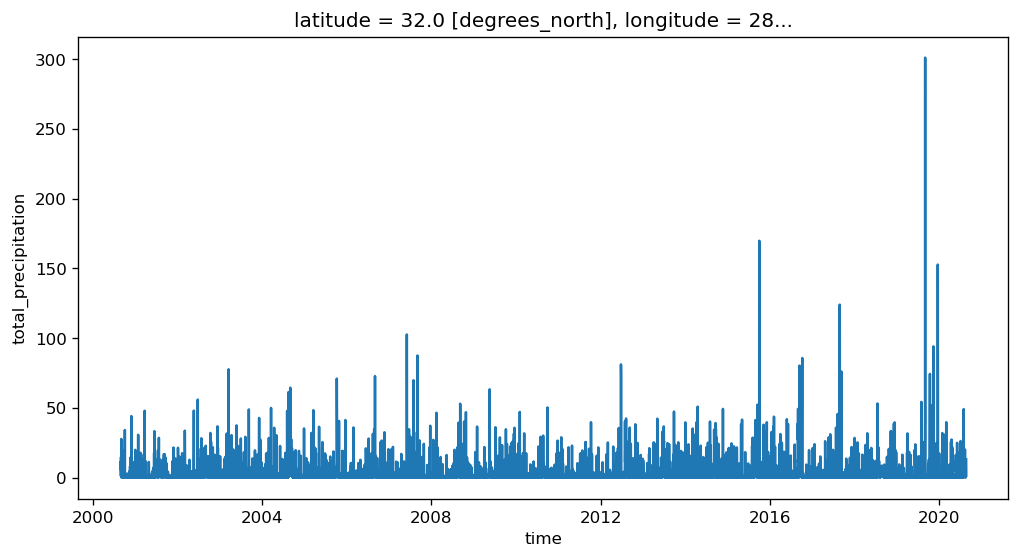

In [8]:
dsss_daily.sel(latitude=32, longitude=-80+360).plot()

In [9]:
dsss_daily.to_netcdf('era5_CHS_precip_08252000_08242020.nc')

# 2) 95% Values of Daily Precipitation

In [10]:
dsss_daily = xr.open_dataset('era5_CHS_precip_08252000_08242020.nc')

CHS_95 = dsss_daily.quantile(0.95, dim='time')

CHS_95

<xarray.Dataset> Size: 4kB
Dimensions:              (latitude: 21, longitude: 21)
Coordinates:
  * latitude             (latitude) float32 84B 35.0 34.75 34.5 ... 30.25 30.0
  * longitude            (longitude) float32 84B 280.0 280.2 ... 284.8 285.0
    quantile             float64 8B 0.95
Data variables:
    total_precipitation  (latitude, longitude) float64 4kB 16.45 16.52 ... 16.41

Text(0.5, 1.0, 'CDF of 95% Values of Daily Precipitation in CHS')

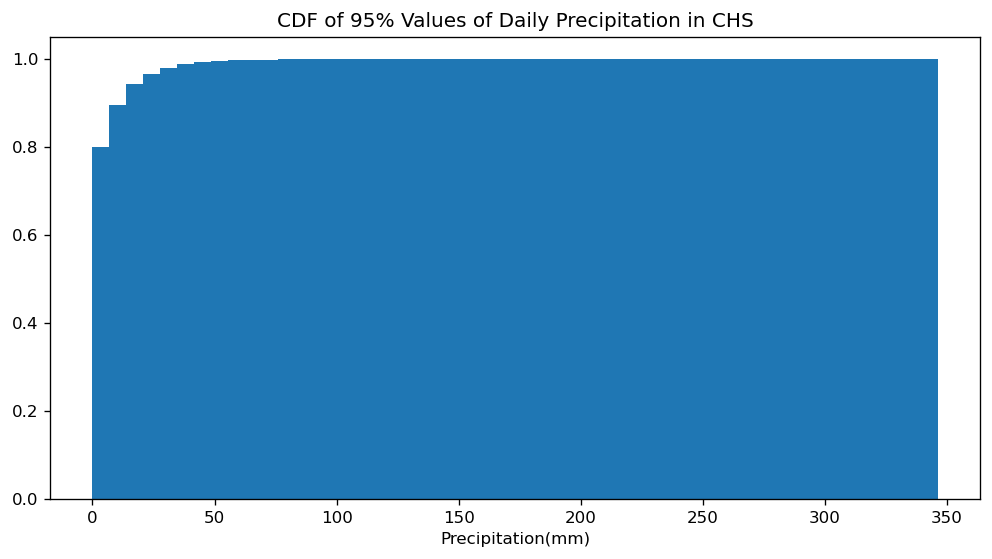

In [11]:
# turn to np?
CHS_flat = dsss_daily['total_precipitation'].values.flatten()
CHS_sorted = np.sort(CHS_flat)

plt.hist(CHS_sorted, bins=50, density=True, cumulative=True)
plt.xlabel('Precipitation(mm)')
plt.title('CDF of 95% Values of Daily Precipitation in CHS')

# 3) Compostie mean & anomaly maps

In [12]:
dss

<xarray.DataArray 'total_precipitation' (time: 175320, latitude: 721,
                                         longitude: 1440)> Size: 728GB
[182024236800 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1MB 2000-08-25 ... 2020-08-24T23:00:00
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

In [ ]:
# Composite mean calculaion 
lons_US = [-67+360, -124+360]
lats_US = [25, 50]

precip_US = ds['total_precipitation'].sel(latitude=slice(lats_US[1], lats_US[0]), longitude=slice(lons_US[1], lons_US[0]))

precip_US


precip_US_95 = precip_US.where(precip_US > CHS_95)
precip_US_95 = precip_US_95.to_dataarray()
US_mean = precip_US_95.mean(dim='time')


In [ ]:
fig, ax = plt.subplots(
    figsize=(10,5),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
ax.coastlines()
ax.add_feature(cfeature.STATES)

US_CM = US_mean.plot(
    ax = ax,
    transform = ccrs.PlateCarree(),
    cmap='Blues'
)


In [ ]:
# long term mean calculations

precip = ds['total_precipitation']

precip = precip.sel(time=slice('1981-01-01 00:00', '2010-12-31 23:59'))

ltm = precip.mean(dim='time')

<xarray.DataArray 'total_precipitation' (time: 262968, latitude: 721,
                                         longitude: 1440)> Size: 1TB
[273023896320 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 2MB 1981-01-01 ... 2010-12-31T23:00:00
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

In [ ]:
anom = US_mean-ltm

In [ ]:
fig, ax = plt.subplots(
    figsize=(10,5),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
ax.coastlines()
ax.add_feature(cfeature.STATES)

US_anom = anom.plot(
    ax = ax,
    transform = ccrs.PlateCarree(),
    cmap='coolwarm'
)
